In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
guests = pd.read_excel("data/guests.xlsx", index_col=0)
guests.drop("guest", axis= 1, inplace = True)
guests = 1 - guests 
vec_discount = guests["discount"].values #converts the discount column to a vector

In [3]:
hotels = pd.read_excel("data/hotels.xlsx", index_col=0)
vec_prices = hotels["price"].values

In [4]:
preferences = pd.read_excel("data/preferences.xlsx", index_col=0)
preferences["guest"] = pd.to_numeric(preferences["guest"].str.replace('guest_','')) - 1
preferences["hotel"] = pd.to_numeric(preferences["hotel"].str.replace('hotel_','')) - 1
pref_pivoted = pd.pivot_table(preferences, index ='guest', columns ='hotel', values= "priority" , aggfunc="min") #it pivots the original dataframe to get to a matrix-like format
rank_matrix = pref_pivoted.rank(axis = 1, method="dense").values #reorders preferences

In [5]:
def to_utility_matrix(rank_matrix):
  user_utility = []
  for row in rank_matrix:
    utility_values = np.linspace(start=1, stop= 0.1, num=len(set(row[~np.isnan(row)]))) #utility goes from 1 to 0.1 split evenly between preferences
    user_utility.append([utility_values[int(i)-1] if i == i else i for i in row ]) #i == i to check if i is not nan 
  return np.nan_to_num(np.array(user_utility), nan = 0)

In [6]:
utility_matrix = to_utility_matrix(rank_matrix)

In [7]:
def results(choice_matrix, vec_prices=vec_prices, vec_discount=vec_discount, utility_matrix=utility_matrix):
  guests_placed = choice_matrix.sum(axis=1).sum()
  rooms_occupied = choice_matrix.sum(axis=0).sum()
  hotels_occupied = np.where(choice_matrix.sum(axis=0) > 0, 1, 0).sum()
  prices_matrix = vec_prices * choice_matrix #all 1s in the matrix will be replaced by that hotel's price
  discount_matrix = np.multiply(prices_matrix, vec_discount[:, np.newaxis]) #the room price is then discounted for each user
  revenue = discount_matrix.sum()
  utility = np.multiply(choice_matrix, utility_matrix).sum()
  return([guests_placed, rooms_occupied, hotels_occupied, revenue, utility])

In [8]:
def random_model(hotels, vec_prices, vec_discount, rank_matrix, t=1000):
  guest_count, room_count = rank_matrix.shape[0] , hotels["rooms"].sum()
  least = min([guest_count, room_count])
  vec_rooms = np.repeat(hotels["price"], hotels["rooms"]).index.values #Denormalized the dataframe
  res = [] 
  for _ in range(t):
    choice_matrix = np.zeros(rank_matrix.shape) #creates filled with zeros 4000 x 400
    random_rooms = np.random.choice(vec_rooms, least, replace=False ) #selects randomly 4000 rooms from all possible rooms
    choice_matrix[tuple(range(least)),tuple(random_rooms)] = 1 #assign 1 in the choice matrix where room is occupied
    res.append(results(choice_matrix, vec_prices, vec_discount))
  return np.array(res)

In [9]:
def preference_model(hotels, rank_matrix):
  rank_matrix_filled, choice_matrix  = np.nan_to_num(rank_matrix), np.zeros(rank_matrix.shape) 
  rooms = hotels["rooms"].values
  for idx, row in enumerate(rank_matrix_filled):
    c = np.multiply(row, np.where(rooms > 0, 1, 0) ) #sets preferences values to 0 where there is no room availability
    try:
      user_choice = np.where(c == np.min(c[np.nonzero(c)]), 1, 0) #The minimum nonzero is converted to 1 and the rest to 0
      choice_matrix[(idx),] = user_choice
      rooms = rooms - user_choice #subtract 1 from the room availability where it's now occupied 
    except ValueError: #pass if array are all zeros
     pass
  return  results(choice_matrix)

In [10]:
def room_model(hotels, rank_matrix):
    choice_matrix = np.zeros(rank_matrix.shape) 
    pref_pivoted = pd.DataFrame(rank_matrix).T
    pref_pivoted["price"] = hotels["price"]
    pref_pivoted["rooms"] =  hotels["rooms"] #add columns with number of rooms and price per hotel
    h_rooms = pref_pivoted.sort_values(by=['rooms', 'price'], ascending=[False, True]) # DF sorted by number of rooms and price
    h_rooms = h_rooms.drop(columns=["rooms","price"]) # drop columns 'rooms' and 'price'
    rooms = hotels["rooms"].values # available rooms per hotel

    for h, rows in h_rooms.iterrows():                          
        df_pref = pd.DataFrame(rows.values, columns=['values']) # for each row in h_rooms: create DF with row values (preferences) and index
        df_pref['index'] = df_pref.index.values 
        sorted_guests = df_pref.dropna().sort_values(by=['values','index'])['index'] # dropna, sort DF and consider 'index' of the remaining guests
        selected_guests = sorted_guests[:rooms[h]].values # select as many guests as possible (maximum number: rooms[h])
        
        for guest in selected_guests:
            choice_matrix[guest][h] = 1 # add selected guests to the choice_matrix
            h_rooms.iloc[:][guest]= np.nan # for each selected guest transform preference values in np.nan 
    return  results(choice_matrix)

In [11]:
def price_model(hotels, rank_matrix):
    choice_matrix = np.zeros(rank_matrix.shape) #define matrix with zeros, same shape as rank_matrix
    pref_pivoted = pd.DataFrame(rank_matrix).T 
    pref_pivoted["price"] = hotels["price"] #add a column with prices per hotel
    pref_pivoted["rooms"] = hotels["rooms"] #add a column with number of rooms per hotel
    pref_by_price = pref_pivoted.sort_values(by=['price', 'rooms'], ascending=[True, False]) #sorted by price and more rooms
    pref_by_price = pref_by_price.drop(columns=["rooms","price"]) #drop columns: price and rooms
    free_rooms = hotels["rooms"].values #vector of rooms from dataset hotels
    
    for i, rows in pref_by_price.iterrows(): #for hotel with name i, consider the row of guests
        hotel_i = pd.DataFrame(rows.values, columns=['values']) #transforming the row in dataframe 
        hotel_i['index'] = hotel_i.index.values #consider the index of values
        hotel_i = hotel_i.dropna().sort_values(by=['values','index'])['index'] #soting
        guest4hotel_i = hotel_i[:free_rooms[i]].values #take values of guests for free rooms
        
        for name_guest in guest4hotel_i:
            choice_matrix[name_guest][i] = 1
            pref_by_price.iloc[:][name_guest]= np.nan
    return results(choice_matrix)

In [12]:
random_results_array = random_model(hotels, vec_prices, vec_discount, rank_matrix, t=100000) 

In [13]:
matrix_results = np.array([random_results_array.mean(axis=0),
                           preference_model(hotels, rank_matrix),
                           room_model(hotels, rank_matrix),
                           price_model(hotels, rank_matrix)])

In [14]:
pd.DataFrame(matrix_results, index = ['Random Model','Preference Model','Availability Model','Price Model'], columns = ['Guests','Rooms','Hotels','Revenue', 'Satisfaction']).astype(int)

,Guests,Rooms,Hotels,Revenue,Satisfaction
Random Model,4000,4000,399,640448,131
Preference Model,3975,3975,400,643597,3895
Availability Model,4000,4000,341,633529,3679
Price Model,3990,3990,383,578798,3685


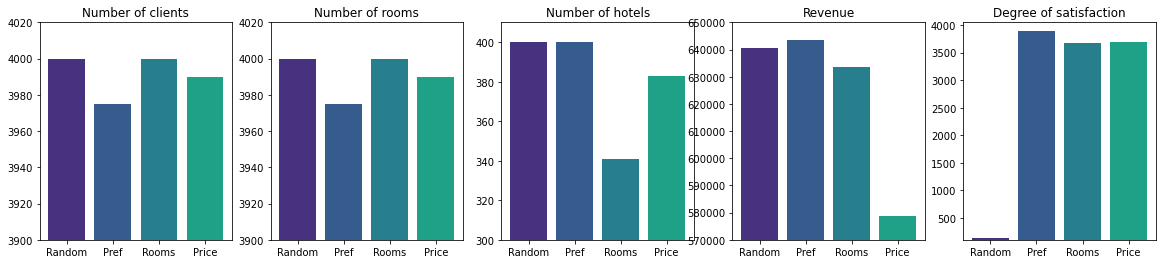

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
x = ['Random', 'Pref', 'Rooms', 'Price']
clr = sns.color_palette("viridis")
axes[0].bar(x, matrix_results[:,0], color = clr )
axes[0].set_title("Number of clients")
axes[0].set_ylim(3900,4020)
axes[1].bar(x, matrix_results[:,1], color = clr)
axes[1].set_title("Number of rooms")
axes[1].set_ylim(3900,4020)
axes[2].bar(x, matrix_results[:,2], color = clr)
axes[2].set_title("Number of hotels")
axes[2].set_ylim(300,410)
axes[3].bar(x, matrix_results[:,3], color = clr)
axes[3].set_title("Revenue")
axes[3].set_ylim(570000,650000)
axes[4].bar(x, matrix_results[:,4], color = clr)
axes[4].set_title("Degree of satisfaction")
axes[4].set_ylim(100,4050);

In [16]:
pd.DataFrame(random_results_array, columns = ['Guests','Rooms','Hotels','Revenue', 'Satisfaction']).describe().round(3)

,Guests,Rooms,Hotels,Revenue,Satisfaction
count,100000.0,100000.0,100000.000,100000.000,100000.000
mean,4000.0,4000.0,399.998,640448.853,131.857
std,0.0,0.0,0.040,1562.564,9.209
min,4000.0,4000.0,399.000,633864.690,95.867
25%,4000.0,4000.0,400.000,639391.908,125.567
50%,4000.0,4000.0,400.000,640450.195,131.720
75%,4000.0,4000.0,400.000,641503.888,138.018
max,4000.0,4000.0,400.000,648352.300,171.644


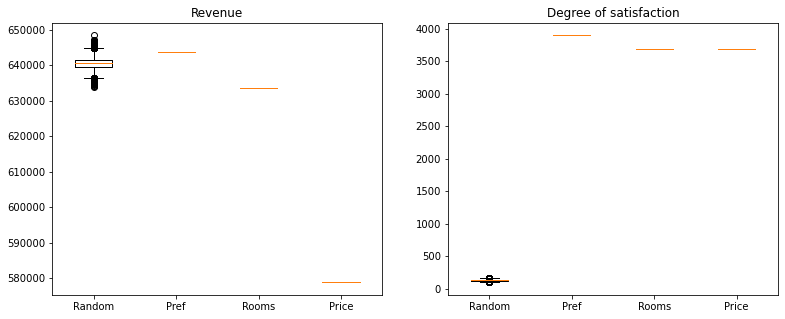

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5)) #values of matrix_results
x = ['Random', 'Pref', 'Rooms', 'Price']
axes[0].boxplot([random_results_array[:,3], matrix_results[1][3], matrix_results[2][3], matrix_results[3][3]], labels = x)
axes[0].set_title("Revenue")
axes[1].boxplot([random_results_array[:,4], matrix_results[1][4], matrix_results[2][4], matrix_results[3][4]], labels = x)
axes[1].set_title("Degree of satisfaction");

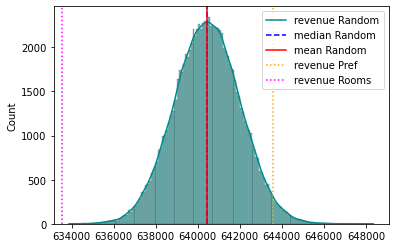

In [18]:
sns.histplot(random_results_array[:,3], color = 'darkcyan', kde=True) #Revenue for Random Model
plt.axvline(np.median(random_results_array[:,3]), color ='b', linestyle='--')
plt.axvline(np.mean(random_results_array[:,3]), color ='r', linestyle='-')
plt.axvline(matrix_results[1][3], color ='orange', linestyle=':')
plt.axvline(matrix_results[2][3], color ='magenta', linestyle=':')
plt.legend(labels=['revenue Random','median Random', 'mean Random', "revenue Pref", "revenue Rooms"]);

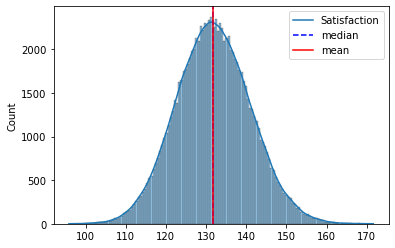

In [19]:
sns.histplot(random_results_array[:,4], kde=True) #Degree of satisfaction for Random Model
plt.axvline(np.median(random_results_array[:,4]), color ='b', linestyle='--')
plt.axvline(np.mean(random_results_array[:,4]), color ='r', linestyle='-')
plt.legend(labels=['Satisfaction','median', 'mean']);